<a href="https://colab.research.google.com/github/chunming1022/segmantic-in-nerf/blob/main/w2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import os
from typing import Optional, Tuple, List, Union, Callable
import math
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange
import matplotlib.image as mpimg  

In [119]:
def init_space(
    length: int,
    points_num: int
) -> torch.Tensor:
  r"""
  Initialize n^3 points in the space of length*length*length.
  """
  z, y, x = torch.meshgrid(
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32),
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32),
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32)
      )
  points = torch.stack(
      [x, -y, z],
      dim=-1
  )
  return points

In [120]:
def vote_building(
    c2w: torch.Tensor,
    points: torch.Tensor,
    mask_result: torch.Tensor,
    focal_length: float
) -> torch.Tensor:
  r"""
  Mapping spatial points to semantic matrices for voting on building categories
  """
  scores=[]
  origin = c2w[:3,-1].expand(points.shape)
  points_in_camera = torch.sum((points-origin)[..., None, :] * (c2w[:3, :3].inverse()), dim=-1)
  points_in_camera = -points_in_camera / points_in_camera[..., None, -1] * focal_length
  h, w = mask_result.shape
  points_in_camera = points_in_camera.reshape(-1, points.shape[-1])
  for point in points_in_camera:
    vote=0.0
    if((point[0] >= -w * .5) and (point[0] <= w * .5 - 1) and (point[1] >= -h * .5) and (point[1] <= h * .5 -1)):
      for x in [math.floor(point[0]), math.ceil(point[1])]:
        for y in [math.floor(point[1]), math.ceil(point[1])]:
          vote = max(mask_result[h//2-1-y][x+w//2], vote) 
    scores.append(torch.tensor(vote))
  scores=torch.stack(scores, dim=0)
  scores=scores.reshape(points.shape[0], points.shape[1], points.shape[2], 1)
  return scores

# Part **1**

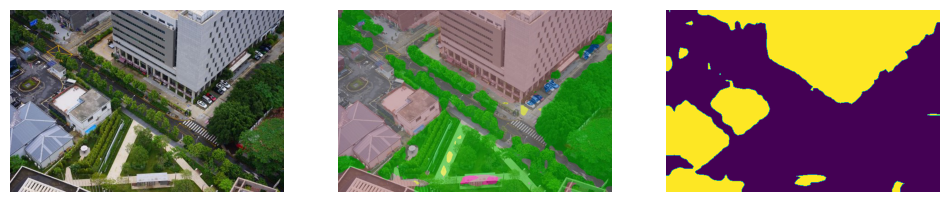

In [116]:
data = np.load('data.npz')
focal_length = data['focal_length']
poses = data['poses']
masks = data['masks']

fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(1, 3, 1)
img1 = mpimg.imread('sz.jpg')
img1 = np.flip(img1, (0, 1))
bx = fig.add_subplot(1, 3, 2)
img2 = mpimg.imread('sz_test.jpg')
cx = fig.add_subplot(1, 3, 3)
ax.axis('off')
bx.axis('off')
cx.axis('off')
ax.imshow(img1)
bx.imshow(img2)
cx.imshow(masks[0])

In [117]:
def plot_vector(
    poses
):
    dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
    origins = poses[:, :3, -1]
    ax = plt.figure(figsize=(10, 4)).add_subplot(projection='3d')
    _ = ax.quiver(
        origins[..., 0].flatten(),
        origins[..., 1].flatten(),
        origins[..., 2].flatten(),
        dirs[..., 0].flatten(),
        dirs[..., 1].flatten(),
        dirs[..., 2].flatten(), length=0.5, normalize=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('z')
    plt.show()

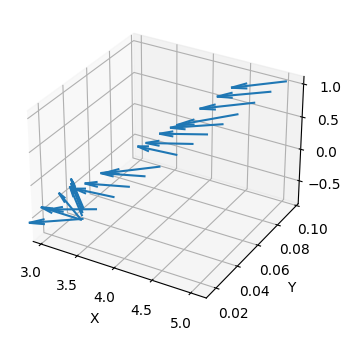

In [118]:
plot_vector(poses = poses)

In [87]:
def plot_scatter(
    points: torch.tensor,
    scores: torch.tensor
):   
    fig = plt.figure(layout = 'constrained', figsize = (10, 4)) 
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    _ = ax.scatter(
          points[...,0],
          points[...,1],
          points[...,2],
          s=20,
          c=vote,
          alpha = 1,
          )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    bx = fig.add_subplot(1, 2, 2, projection='3d')
    __ = bx.scatter(
          points[...,0],
          points[...,1],
          points[...,2],
          vote[...,0],
          vote[...,0],
          vote[...,0],
          alpha = 1,
          )
    bx.set_xlabel('X')
    bx.set_ylabel('Y')
    bx.set_zlabel('Z')
    plt.show()

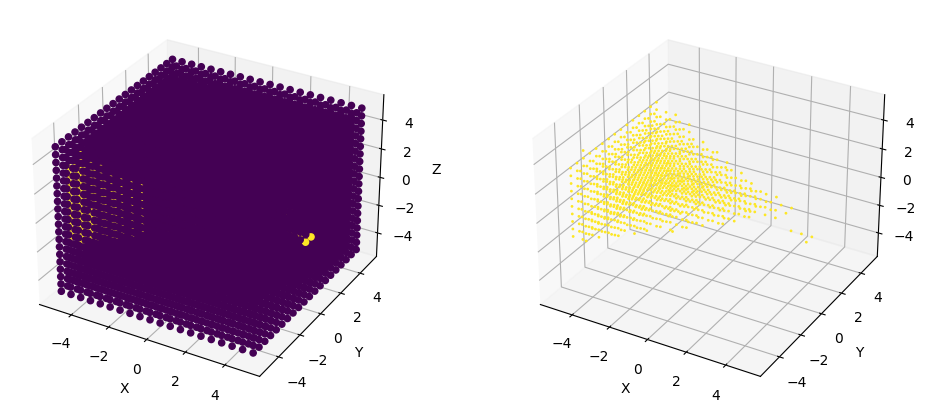

In [88]:
plot_scatter(points = points, scores = vote)

# Part **2**

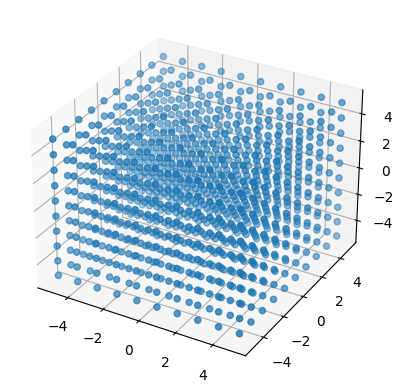

In [122]:
points = init_space(length=10, points_num=10)
ax=plt.figure().add_subplot(projection='3d')
ax.scatter(
      points[...,0],
      points[...,1],
      points[...,2])

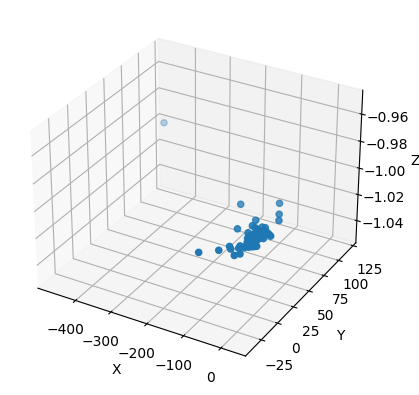

In [123]:
c2w=torch.tensor([[6.8935126e-01, 5.3373039e-01, -4.8982298e-01, -1.9745398e+00],
   [-7.2442728e-01 , 5.0788772e-01 ,-4.6610624e-01, -1.8789345e+00],
   [ 1.4901163e-08 , 6.7615211e-01 , 7.3676193e-01 , 2.9699826e+00],
   [ 0.0000000e+00 , 0.0000000e+00 , 0.0000000e+00 , 1.0000000e+00]])
origin=c2w[:3,-1].expand(points.shape)
location_in_mask=torch.sum((points-origin)[...,None,:]*(c2w[:3,:3].inverse()),dim=-1)
location_in_mask=-location_in_mask/location_in_mask[...,None,-1]

bx=plt.figure().add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
__ = bx.scatter(
      location_in_mask[...,0],
      location_in_mask[...,1],
      location_in_mask[...,2])
bx.set_xlabel('X')
bx.set_ylabel('Y')
bx.set_zlabel('Z')
plt.show()

In [124]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2023-04-04 11:38:08--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-04-04 11:38:08--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  15.9MB/s    in 0.8s    

2023-04-04 11:38:09 (15.9 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



(100, 100, 3)


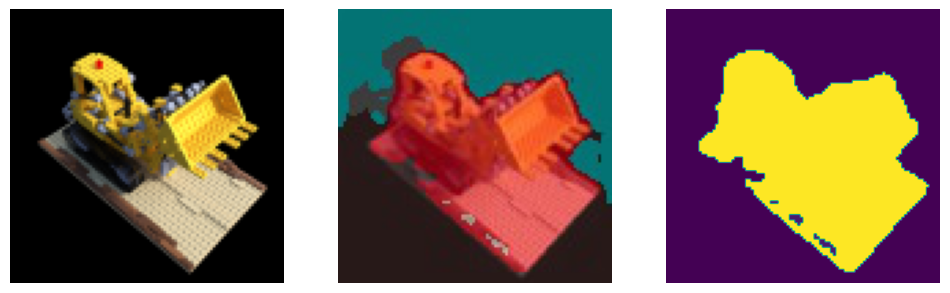

In [134]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

height, width = images.shape[1:3]

testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(testimg)
bx = fig.add_subplot(1, 3, 3)
cx = fig.add_subplot(1, 3, 2)
test_seg = mpimg.imread('test_img_result.jpg')
mask_result = np.load('test_img.npz')
mask_result = mask_result['result']
ax.axis('off')
bx.axis('off')
cx.axis('off')
bx.imshow(mask_result)
cx.imshow(test_seg)
print(testimg.shape)

<ipython-input-120-0f89584300a8>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores.append(torch.tensor(vote))


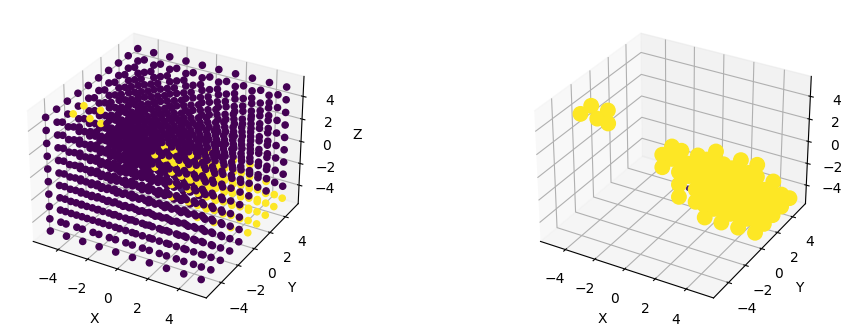

In [137]:
points = init_space(length=10, points_num=10)
scores = vote_building(c2w=torch.from_numpy(testpose), points=points, mask_result=torch.from_numpy(mask_result), focal_length=focal)
fig = plt.figure(figsize = (12, 4))
ax=fig.add_subplot(1, 2, 1, projection='3d')
_ = ax.scatter(
      points[...,0],
      points[...,1],
      points[...,2],
      s=20,
      c=scores,
      alpha = 1,
      )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
bx=fig.add_subplot(1, 2, 2, projection='3d')
__ = bx.scatter(
      points[...,0],
      points[...,1],
      points[...,2],
      scores[...,0],
      scores[...,0],
      scores[...,0],
      alpha = 1,
      )
bx.set_xlabel('X')
bx.set_ylabel('Y')
bx.set_zlabel('Z')
plt.show()